# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [38]:
import tensorflow as tf
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Activation
from keras.optimizers import SGD

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.3.1


In [55]:
# Initialize the model
model = Sequential()

# Convolution 7x7/2 # Input pictures 224x224 RGB
model.add(Conv2D(64, (7, 7), strides=(2, 2), activation='relu', name='conv/7x7_2', input_shape=(224, 224, 3)))

# Max pool 3x3/2
max_pool_332 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), name='max_pool/3x3_2')
model.add(max_pool_332)

# # Convolution 3x3/1
model.add(Conv2D(192, (3, 3), strides=(1, 1), activation='relu', name='conv/3x3_1'))

# # Max pool 3x3/2
model.add(max_pool_332)

# Inception (3a)

# Inception (3b)

# Max pool 3x3/2

# Inception (4a)

# Inception (4b)

# Inception (4c)

# Inception (4d)

# Inception (4e)

# Max pool 3x3/2

# Inception (5a)

# Inception (5b)

# Avg pool 7x7/1

# Dropout (40%)

# Linear

# Softmax

In [56]:
model.compile(optimizer="sgd", loss='categorical_crossentropy')

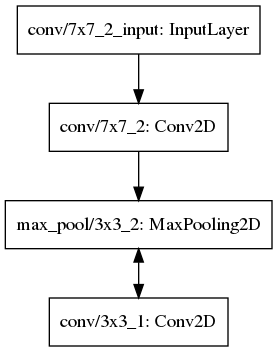

In [57]:
tf.keras.utils.plot_model(model)

In [43]:
model.build(input_shape=(224, 224, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv/7x7_2 (Conv2D)          (None, 109, 109, 64)      9472      
_________________________________________________________________
max_pool/3x3_2 (MaxPooling2D (None, 54, 54, 64)        0         
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
_________________________________________________________________


## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [ ]:
# code here